In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../utils')
print(sys.path)
import numpy as np
from load_dataset import *
import os

['/home/shiqi/code/Project2-sensor-case/model_combination_Argos/pca_from_formulation', '/home/shiqi/anaconda3/envs/torch/lib/python39.zip', '/home/shiqi/anaconda3/envs/torch/lib/python3.9', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/site-packages', '../utils']


In [3]:
import yaml

config_path = '/home/shiqi/code/Project2-sensor-case/model_combination_Argos/pca_from_formulation/output/experiment_13/config.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

In [4]:
save_dir = config['save_dir']
train_data_dir = config['data_dir_list']
test_data_dir = config['test_dir_list']
# data_dir_list = test_data_dir

train_loss = np.load(os.path.join(save_dir, 'train_losses.npy'))
test_loss = np.load(os.path.join(save_dir, 'test_losses.npy'))


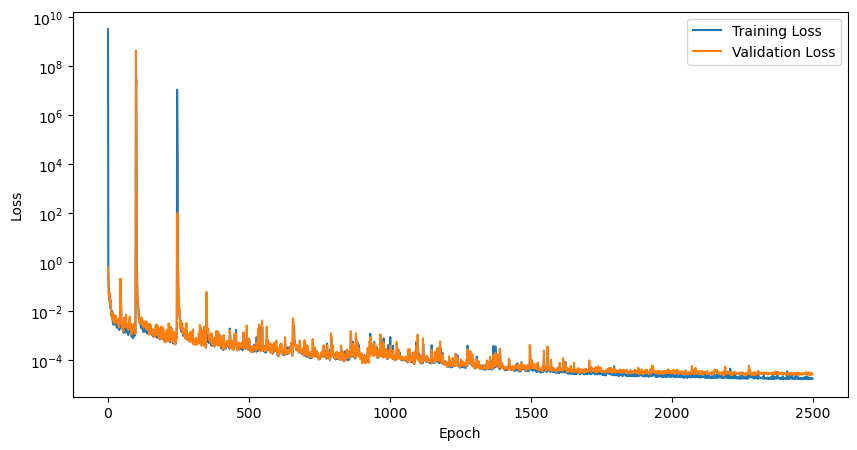

In [5]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [6]:
import pca_koopman_dir as km
import torch
# Device
device = 'cpu'
print('Device:', device)

# todo: multi nu
nu_list = config['nu_list']

# Data loader
x_dataset, u_dataset, nu_dataset = [], [], []
for i in range(len(nu_list)):
    nu = nu_list[i]
    config['data_dir'] = config['data_dir_list'][i]
    x_data, u_data, nu_data, n_features, n_inputs = data_preparation_xu(config, nu_list, nu)
    x_dataset.append(x_data)
    u_dataset.append(u_data)
    nu_dataset.append(nu_data)

# Params
params = km.Params(n_features, n_inputs, config)

# Model
# Model
if config['experiment'] == 'linear':
    model, x_pca_scaled = km.build_model_linear_multi_nu(params, x_dataset, u_dataset)
if config['experiment'] == 'DicWithInputs':
    model, x_pca_scaled = km.build_model_DicWithInputs_multi_nu(params, x_dataset, u_dataset)
if config['experiment'] == 'MatrixWithInputs':
    model, x_pca_scaled = km.build_model_MatrixWithInputs_multi_nu(params, x_dataset, u_dataset)
model = model.to(device)

Device: cpu
0
1
2


In [7]:
model.load_state_dict(torch.load(os.path.join(save_dir, 'model.pth'), map_location=device))

<All keys matched successfully>

In [8]:
def load_data(begin, end, train_data_dir, nu_list):
    x_dataset = []
    u_dataset = []
    nu_dataset = []
    window_size = end - begin

    for i in range(len(train_data_dir)):
        data_dir = train_data_dir[i]
        nu = nu_list[i]
        nu = torch.tensor(build_nu(nu_list, window_size, nu), dtype=torch.int16)
        for item in os.listdir(data_dir):
            data_file_path = os.path.join(data_dir, item)

            # Check if the file exists before trying to load it
            if os.path.exists(data_file_path) and item.endswith('.npy'):
                data_dict = np.load(data_file_path, allow_pickle=True).item()
                x_data, _, u_data, _ = load_dataset(data_dict)
                x_dataset.append(x_data[begin:end, :])
                u_dataset.append(u_data[begin:end, :])
                nu_dataset.append(nu)
            else:
                print(f"File not found: {data_file_path}")
    
    return x_dataset, u_dataset, nu_dataset

def generate_trajectories(x_dataset, u_dataset, nu_dataset, model, device):
    x_data_pred_traj = []
    x_data_pca_traj = []
    x_data_pca_pred_traj = []
    window_size = len(x_dataset[0])

    for x_data, u_data, nu_data in zip(x_dataset, u_dataset, nu_dataset):
        steps = window_size    

        x_data = torch.tensor(x_data, dtype=torch.float32).to(device)
        u_data = torch.tensor(u_data, dtype=torch.float32).to(device)
        x_pred = torch.zeros_like(x_data).to(device)
        x_pred[0, :] = x_data[0, :]
        nu = nu_data[0:1, :]
        x0 = model.encode(x_data[0, :].reshape(1, -1), nu)
        
        for step in range(1, steps):
            u = u_data[step - 1, :].reshape(1, -1)
            x1 = model.latent_to_latent_forward(x0, u, nu)
            x_pred[step, :] = model.decode(x1, nu)
            x0 = x1
        
        x_data_pred_traj.append(x_pred.detach().cpu().numpy())

        x_pca_true = model.std_layer_1.transform(x_data.detach(), nu_data)
        x_pca_true = model.pca_transformer.transform(x_pca_true)
        x_pca_pred = model.std_layer_1.transform(x_pred.detach(), nu_data)
        x_pca_pred = model.pca_transformer.transform(x_pca_pred)
        
        x_data_pca_traj.append(x_pca_true)
        x_data_pca_pred_traj.append(x_pca_pred)

    return x_data_pred_traj, x_data_pca_traj, x_data_pca_pred_traj

In [9]:
begin, end = 1, 150
window_size = end - begin
x_dataset_train, u_dataset_train, nu_dataset_train = load_data(begin, end, train_data_dir, nu_list)
x_data_pred_traj_train, x_data_pca_traj_train, x_data_pca_pred_traj_train = generate_trajectories(x_dataset_train, u_dataset_train, nu_dataset_train, model, device)
x_dataset_test, u_dataset_test, nu_dataset_test = load_data(begin, end, test_data_dir, nu_list)
x_data_pred_traj_test, x_data_pca_traj_test, x_data_pca_pred_traj_test = generate_trajectories(x_dataset_test, u_dataset_test, nu_dataset_test, model, device)

0
1
2
0
1
2


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_relative_diff(x_true, x_pred):
    row_norm_diff = np.linalg.norm(x_true - x_pred, axis=1, ord=2)
    max_norm = np.max(np.linalg.norm(x_true, axis=1, ord=2))
    relative_diff = row_norm_diff / max_norm
    return relative_diff

def calculate_mean_relative_diff_set(x_true_traj, x_pred_traj):
    relative_diffs = [calculate_relative_diff(x_true, x_pred) for x_true, x_pred in zip(x_true_traj, x_pred_traj)]
    mean_relative_diffs = np.mean(relative_diffs, axis=0)
    return mean_relative_diffs

def plot_mean_relative_diff(x_true_traj_train, x_pred_traj_train, x_true_traj_test, x_pred_traj_test):
    mean_relative_diffs_train = calculate_mean_relative_diff_set(x_true_traj_train, x_pred_traj_train)
    mean_relative_diffs_test = calculate_mean_relative_diff_set(x_true_traj_test, x_pred_traj_test)

    plt.figure(figsize=(10, 4))
    
    plt.plot(mean_relative_diffs_train, color='mediumseagreen')
    plt.plot(mean_relative_diffs_test, label='Validation Set', color='pink')
    
    plt.xlabel('Prediction Step')
    plt.ylabel('Mean Relative Diff')
    plt.title('Mean Relative Diff on Training Set')
    plt.legend()
    plt.show()

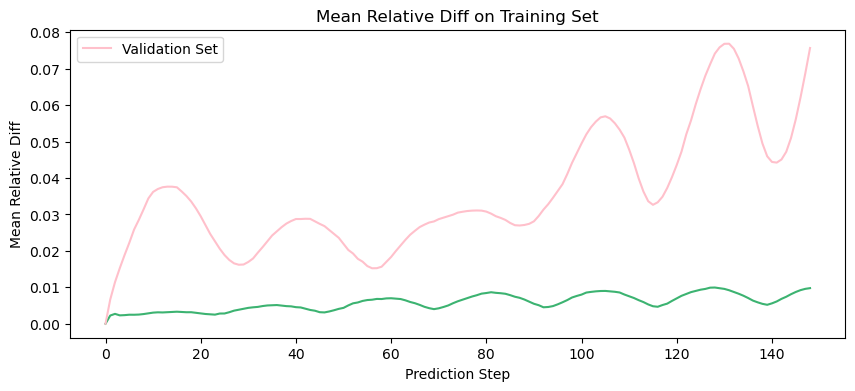

In [11]:
plot_mean_relative_diff(x_data_pca_traj_train, x_data_pca_pred_traj_train, x_data_pca_traj_test, x_data_pca_pred_traj_test)

In [12]:
mean_relative_diffs_train = calculate_mean_relative_diff_set(x_data_pca_traj_train, x_data_pca_pred_traj_train)
mean_relative_diffs_test = calculate_mean_relative_diff_set(x_data_pca_traj_test, x_data_pca_pred_traj_test)
np.save(os.path.join('/home/shiqi/code/Project2-sensor-case/model_combination_Argos/pca_from_formulation/data_for_document/20240708', 'mean_relative_diffs_train_MatrixWithInputs.npy'), mean_relative_diffs_train)
np.save(os.path.join('/home/shiqi/code/Project2-sensor-case/model_combination_Argos/pca_from_formulation/data_for_document/20240708', 'mean_relative_diffs_test_MatrixWithInputs.npy'), mean_relative_diffs_test)

In [13]:
def calculate_relative_error(x_true, x_pred):
    return np.linalg.norm(x_true - x_pred, ord = 'fro') / np.linalg.norm(x_true, ord = 'fro')

def calculate_mean_relative_error(x_true_traj, x_pred_traj):
    return np.mean([calculate_relative_error(x_true, x_pred) for x_true, x_pred in zip(x_true_traj, x_pred_traj)])

def plot_relative_error(x_true_traj_train, x_pred_traj_train, x_true_traj_test, x_pred_traj_test):
    mean_relative_errors_train = []
    mean_relative_errors_test = []
    for i in range(len(x_true_traj_train)):
        mean_relative_errors_train.append(calculate_relative_error(x_true_traj_train[i], x_pred_traj_train[i]))
    for i in range(len(x_true_traj_test)):
        mean_relative_errors_test.append(calculate_relative_error(x_true_traj_test[i], x_pred_traj_test[i]))
    fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(9, 7))
    
    ax0.hist(mean_relative_errors_train, bins=50, density=True, histtype='bar', facecolor='yellowgreen', alpha=0.75)
    ax0.set_xlabel('Relative Error')
    ax0.set_ylabel('Frequency')
    ax0.set_title('Training Set')
    
    ax1.hist(mean_relative_errors_test, bins=50, density=True, histtype='bar', facecolor='pink', alpha=0.75)
    ax1.set_title('Validation Set')
    ax1.set_xlabel('Relative Error')
    ax1.set_ylabel('Frequency')
    
    plt.subplots_adjust(hspace=0.4)
    plt.show()


def calculate_relative_error_set(x_true, x_pred):
    row_norm_diff = np.linalg.norm(x_true - x_pred, axis=1, ord=2)
    total_norm_true = np.linalg.norm(x_true, ord='fro')
    return row_norm_diff / total_norm_true

In [14]:
relative_error_train = calculate_mean_relative_error(x_data_pca_traj_train, x_data_pca_pred_traj_train)
relative_error_test = calculate_mean_relative_error(x_data_pca_traj_test, x_data_pca_pred_traj_test)
print(f'Relative error on Training Data: {relative_error_train}', f'Relative error on Test Data: {relative_error_test}')

Relative error on Training Data: 0.010874277912080288 Relative error on Test Data: 0.0809856653213501


In [15]:
# relative_errors = calculate_relative_error_set(x_data_pca_traj[0], x_data_pca_pred_traj[0])
# plt.plot(relative_errors)

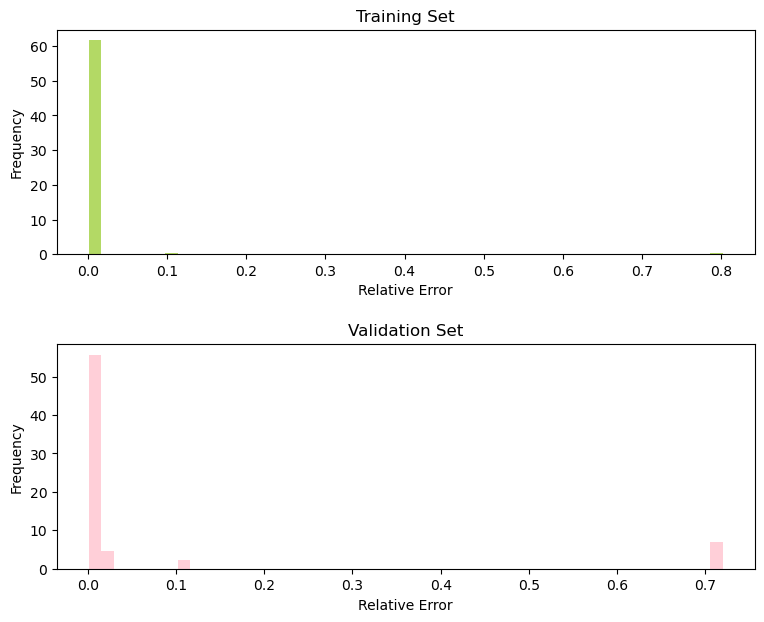

In [16]:
plot_relative_error(x_data_pca_traj_train, x_data_pca_pred_traj_train, x_data_pca_traj_test, x_data_pca_pred_traj_test)

In [17]:
mean_relative_errors_train = []
mean_relative_errors_test = []
for i in range(len(x_data_pca_traj_train)):
    mean_relative_errors_train.append(calculate_relative_error(x_data_pca_traj_train[i], x_data_pca_pred_traj_train[i]))
for i in range(len(x_data_pca_traj_test)):
    mean_relative_errors_test.append(calculate_relative_error(x_data_pca_traj_test[i], x_data_pca_pred_traj_test[i]))

np.save(os.path.join('/home/shiqi/code/Project2-sensor-case/model_combination_Argos/pca_from_formulation/data_for_document/20240708', 'mean_relative_error_train_MatrixWithInputs.npy'), mean_relative_errors_train)
np.save(os.path.join('/home/shiqi/code/Project2-sensor-case/model_combination_Argos/pca_from_formulation/data_for_document/20240708', 'mean_relative_error_test_MatrixWithInputs.npy'), mean_relative_errors_test)


[28, 6, 70, 62, 57, 35, 26, 139, 22, 108, 8, 7, 23, 55, 59, 129, 143, 50, 107, 56]


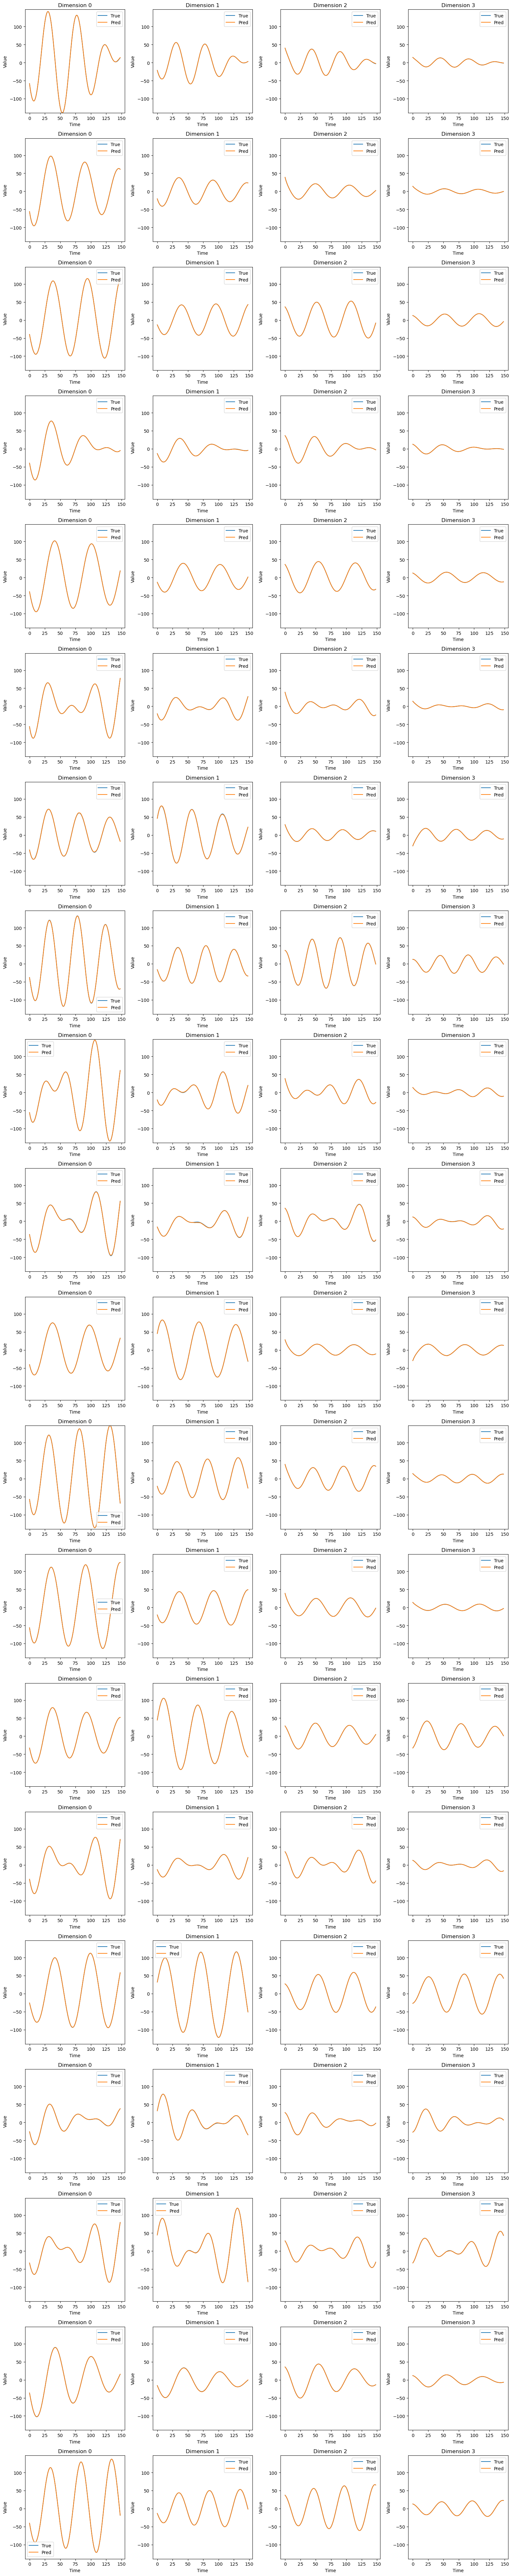

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import random

def plot_random_trajectories(x_data_pca_traj, x_data_pca_pred_traj, num_samples=20, seed=42):
    """
    随机选择多个样本并绘制其每个维度的真实值和预测值

    参数:
    - x_dataset: 数据集（用于获取长度）
    - x_data_pca_traj: 真实轨迹数据
    - x_data_pca_pred_traj: 预测轨迹数据
    - num_samples: 随机选择的样本数量
    - seed: 随机种子
    """
    random.seed(seed)

    length = len(x_data_pca_traj)
    ks = random.sample(range(length), k=num_samples)

    print(ks)

    fig, axs = plt.subplots(len(ks), 4, figsize=(16, len(ks) * 4))

    y_min, y_max = float('inf'), float('-inf')

    for k in ks:
        x_true = x_data_pca_traj[k]
        x_pred = x_data_pca_pred_traj[k]
        y_min = min(y_min, np.min(x_true.detach().cpu().numpy()))
        y_max = max(y_max, np.max(x_true.detach().cpu().numpy()))

    for idx, k in enumerate(ks):
        x_true = x_data_pca_traj[k]
        x_pred = x_data_pca_pred_traj[k]

        for dim in range(4):
            ax = axs[idx, dim]
            ax.plot(x_true[:, dim], label='True')  # 绘制真实值
            ax.plot(x_pred[:, dim], label='Pred')  # 绘制预测值
            ax.set_title(f'Dimension {dim}')  # 设置标题
            ax.set_xlabel('Time')  # 设置x轴标签
            ax.set_ylabel('Value')  # 设置y轴标签
            ax.set_ylim([y_min, y_max])
            ax.legend()  # 显示图例

    plt.tight_layout()  # 调整布局
    plt.show()  # 显示图形

# 示例调用
plot_random_trajectories(x_data_pca_traj_train, x_data_pca_pred_traj_train)


In [19]:
# k = 12
# x_true = x_data_pca_traj[k]
# x_pred = x_data_pca_pred_traj[k]
# plt.plot(range(25, 55), x_true[25:55, 1], label='True')
# plt.plot(range(25, 55), x_pred[25:55, 1], label='Pred')
# plt.plot(range(25, 55), np.zeros(30), label = 'zero')
# plt.xlabel('Prediction Step')
# plt.ylabel('Value')
# plt.legend()

In [80]:
# k = 12
# x_true = x_data_pca_traj[k]
# x_pred = x_data_pca_pred_traj[k]
# plt.plot(range(30, 55), x_true[:25, 1], label='True')
# plt.plot(range(30, 55), x_pred[:25, 1], label='Pred')
# plt.plot(range(30, 55), np.zeros(25), label = 'zero')
# plt.xlabel('Prediction Step')
# plt.ylabel('Value')
# plt.legend()

In [81]:
# errors_pca = [x_data_pca_pred_traj[i] - x_data_pca_traj[i] for i in range(len(x_data_pca_pred_traj))]

# cumulative_error_norms_pca = []
# for k in range(4):
#     cur_dim_norm = np.array([np.array([np.linalg.norm(errors_pca[i][:j+1,k]) for j in range(errors_pca[i].shape[0])]) for i in range(len(errors_pca))])
#     cumulative_error_norms_pca.append(cur_dim_norm)




In [82]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 假设 window_size, cumulative_error_norms_pca, x_data_pca_traj 等变量已经定义

# fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 创建一个1行4列的子图布局

# for dim in range(4):
#     # 计算平均相对误差和标准差
#     mean_relative_errors_pca = np.mean([
#         cumulative_error_norms_pca[dim][i] / np.linalg.norm(x_data_pca_traj[i]) 
#         for i in range(len(cumulative_error_norms_pca[dim]))
#     ], axis=0)
#     std_relative_errors_pca = np.std([
#         cumulative_error_norms_pca[dim][i] / np.linalg.norm(x_data_pca_traj[i]) 
#         for i in range(len(cumulative_error_norms_pca[dim]))
#     ], axis=0)

#     # 计算上下误差界限
#     upper_bound = mean_relative_errors_pca + std_relative_errors_pca
#     lower_bound = mean_relative_errors_pca - std_relative_errors_pca

#     # 绘制平均误差曲线
#     axs[dim].plot(range(window_size), mean_relative_errors_pca, '-', label='Mean Cumulative Error')
    
#     # 使用阴影表示误差范围
#     axs[dim].fill_between(range(window_size), lower_bound, upper_bound, color='gray', alpha=0.2)

#     axs[dim].set_xlabel('Prediction Time Step')
#     axs[dim].set_ylabel('Cumulative Error')
#     axs[dim].set_title(f'Dimension {dim}')

# plt.tight_layout()
# plt.show()
